<a id='top'></a>
# Random Forests

### May 2017

<br>
This is a study for a blog post to appear on [Data Simple](http://luisvalesilva.com/datasimple). It will focus on the theory and scikit-learn implementation of the **Random Forest** machine learning (ML) algorithm.
<br><br>

## Contents

1. [Introduction](#intro)
1. [Decision Trees](#trees)
1. [Random Forests](#forests)
1. [Extremely Randomized Trees](#extra_trees)

<br><br>

<a id='intro'></a>
# 1. Introduction

_Random Forests_ are a popular example of an _Ensemble Learning_ method. _Ensemble Learning_ consists on combining multiple ML models in order to achieve higher predictive performance than could be obtained using either of the individual models alone.

_Ensemble Learning_ methods work best when the models are as diverse as possible, providing complementary predictive performance. One way to achieve this is to combine models built using different ML algorithms, to try to combine models making errors on different training set instances. An alternative approach is to use the same ML algorithm, but to train each model on a different random subset of the training data set. This is the appproach taken by _Random Forests_: they combine multiple _Decision Tree_ models trained on different subsets of the training data.

The next section provides an overview of the _Decision Tree_ ML algorithm, which is at the core of Random Forests. More on _Ensemble Learning_ theory later. Before moving on, let's generate some toy data using `scikit-learn`'s `make_blobs` function. Let's make it a two-dimensional data set, in order to allow easy visualization. There will be, say, 300 observations evenly split between three classes (let's call them "Yellow", "Blue", and "Red"). I'll use a high-enough standard deviation (parameter `cluster_std`) to blur out the class boundaries a little bit.

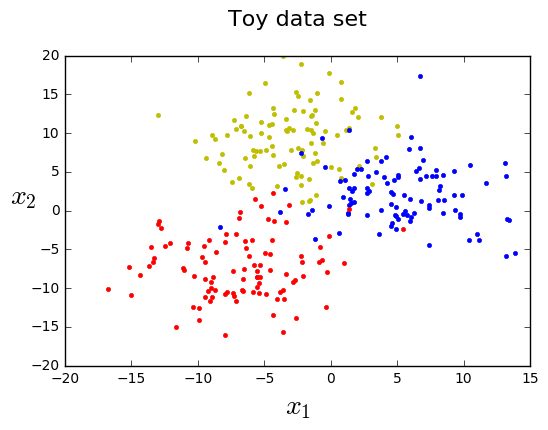

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

# Generate data
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=300, n_features=2, centers=3,
                  cluster_std=4, random_state=42)

# Plot data
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", marker='.')
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", marker='.')
plt.plot(X[:, 0][y==2], X[:, 1][y==2], "rd", marker='.')
plt.xlabel(r"$x_1$", fontsize=20)
plt.ylabel(r"$x_2$", fontsize=20, rotation=0)
plt.title("Toy data set\n", fontsize=16)

#plt.savefig('toy_data.png', dpi=300, bbox_inches='tight')

plt.figure(figsize=(4, 3))

<a id='trees'></a>
# 2. Decision Trees

## 2.1 Making predictions

_Decision Trees_ are powerful ML algorithms capable of fitting complex data sets. The [Wikipedia page](https://en.wikipedia.org/wiki/Decision_tree_learning) on Decision Tree Learning presents the following definition:

> A decision tree is a flow-chart-like structure, where each internal (non-leaf) node denotes a test on an attribute, each branch represents the outcome of a test, and each leaf (or terminal) node holds a class label. The topmost node in a tree is the root node.

In order to classify a data instance, all you need to do is traverse the flow chart, answering all the tests, until you reach a leaf node. Each test will be a question on a specific feature in the data. The class labeling of the leaf node the new instance ends up in is the predicted class.

Let's grow a _Decision Tree_ on our data to take a closer look at how this works in practice. `scikit-learn` makes this ridiculously easy, of course.

In [2]:
from sklearn.tree import DecisionTreeClassifier

# Instantiate the classifier class
tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)

# Grow a Decision Tree
tree_clf.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best')

We have grown a tree on our 2-D data set. Classifying new examples would be simple:

In [3]:
import numpy as np

def predict_class(data_point, classes=['Yellow', 'Blue', 'Red']):
    # Convert to appropriate numpy array
    data_point = np.array(data_point).reshape(1, -1)
    
    # Classify
    result = tree_clf.predict(data_point)
    
    # Print output
    print('Predicted class for point {}: {}'.format(data_point,
                                                    classes[np.asscalar(result)]))
    
predict_class([-5, 10])
predict_class([10, 5])
predict_class([-10, -10])

Predicted class for point [[-5 10]]: Yellow
Predicted class for point [[10  5]]: Blue
Predicted class for point [[-10 -10]]: Red


We can visualize the Decision Tree model to inspect its structure and see how it makes decisions. We can use the `dot` tool in the `graphviz` package. We start by generating a graph definition as a `.dot` file, using the `export_graphviz` method. We can then convert the `.dot` file to a `.png` image file.

In [10]:
from sklearn.tree import export_graphviz

export_graphviz(tree_clf, out_file='tree.dot',
                feature_names=['x1', 'x2'],
                class_names=['Yellow', 'Blue', 'Red'],
                rounded=True, filled=True)

Generate `.png` image using `graphviz` package:

```
$ dot -Tpng tree.dot -o tree.png
```

Here's the tree visualization.

![Tree](tree.png)

We can now see the exact way the model predicts new instance classes. It starts off at the root node, with all 300 training examples split evenly between the three classes, and asks whether feature $x_2$ value is lower than or equal to $-1.3707$. It splits the data in two groups according to the answer and then goes on to ask another question in each of the two following internal nodes. These, in turn, split the data between two groups each. Since we set argument `max_depth=2`, the tree stops here, with four leaf nodes providing the final prediction.

Let's use one of the instances predicted above as an example: $x_1 = -5, x_2 = 10$. The answer to the root node question is `False`, since $x_2 > -1.3707$. The answer to the next question is `True`, since $x_1 <= 0.8566$. This brings us to the leaf node predicting class "Yellow".

This structure allows Decision Trees to estimate class probabilities by simply computing the ratio of training instances belonging to each class in the leaf node. For example, for our predicted instance above this tree estimates it belongs to class "Yellow" with 84.6% probaility (88/104; the predicted class), class "Blue" with 8.7% probability (9/104) and class "Red" with 6.7% probability (7/104).

These rules define axis-parallel decision boundaries, dividing the feature space into a series rectangles, each of which predicts only one of the classes. Let's define a function to visualize the decision boundaries and a function to plot them together with the training data using `matplotlib`.

In [4]:
from matplotlib.colors import ListedColormap

def compute_decision_boundaries(clf, X, y, axes):
    x1s = np.linspace(axes[0], axes[1], 300)
    x2s = np.linspace(axes[2], axes[3], 300)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    
    return x1, x2, y_pred

def plot_feature_space(clf, X, y, axes, file_name=None):
    x1, x2, y_pred = compute_decision_boundaries(clf, X, y, axes)
    
    custom_cmap = ListedColormap(['y','b','r'])
    plt.contourf(x1, x2, y_pred, cmap=custom_cmap, alpha=0.1, linewidth=1)

    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", marker='.')
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", marker='.')
    plt.plot(X[:, 0][y==2], X[:, 1][y==2], "rd", marker='.')
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0)
    if file_name is not None:
        plt.savefig(file_name, dpi=300, bbox_inches='tight')
    plt.figure(figsize=(8, 4))

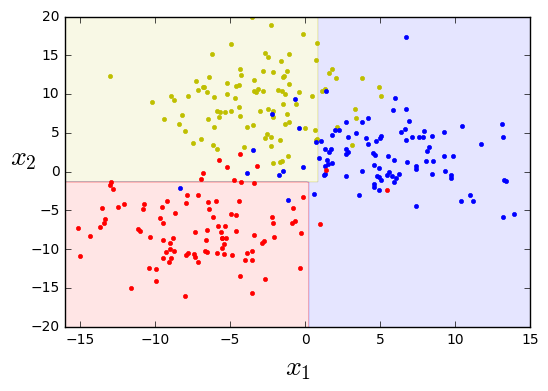

In [6]:
plot_feature_space(tree_clf, X, y, axes=[-16, 15, -20, 20], file_name='max_depth2.png')

## 2.2 "Growing" a _Decision Tree_ model

So this is how a Decision Tree model makes predictions. But how is `scikit-learn` actually growing the tree? There are alternatives, but `scikit-learn` uses the Classification And Regression Tree (CART) algorithm. CART works by splitting the training set in two subsets using a single feature $k$ and a threshold $t_k$, such that the split produces the purest subsets (weighted by their size). This is called the _splitting rule_. It then splits the subsets in the same exact way, then the sub-subsets and so on, recursively, until it cannot find a split that will reduce class impurity of the data. This is known as contructing the _maximum tree_.

The CART algorithm minimizes the following cost function at each split:

$$ J(k, t_k) = \dfrac{m_{left}}{m}I_{left} + \dfrac{m_{right}}{m}I_{right} $$

$$
with
\begin{cases}
  I_{left/right} \text{ impurity of the left/right subset,}\\
  m_{left/right} \text{ number of instances in the left/right subset.}
\end{cases}
$$

So what is the impurity $I$ measure? Typically, this will be the _Gini impurity_ measure is typically used. Formally:

$$ I_G(t) =  1 - \sum_{k=1}^K p_{k,t}^2 $$

$$
with
\begin{cases}
  k \bbox[3pt]{1, . . . , K} \text{ index of the class,}\\
  p_{k,t} \text{ ratio of class $k$ instances among the training instances in node $t$}
\end{cases}
$$

In other words, the Gini impurity measures the probability that a randomly chosen instance from the node would be incorrectly labeled if it was randomly labeled according to the distribution of classes in the node. It does this by first computing the probability $p_{k,t}$ that a randomly chosen instance from the subset of training instances in the node $t$ belongs to class $k$ (simply the ratio of class $k$ instances). It multiplies this probability by itself, which yields the probability $p_{k,t}^2$ that that instance would be correctly labeled if it was randomly labeled according to the distribution of classes in the node (again, simply the ratio of class $k$ instances). It then sums up the probabilities across all classes $K$ and finally computes the probability that the instance would be incorrectly classified by subtracting the previous probability from the unity. The Gini impurity is thus reduced to zero when the node is pure, i.e. all instances in the node belong to the same class, since in that case $p_{k,t} = 1$ for the represented class (and 0 for all others) and thus $p_{k,t}^2 = 1$, resulting in $I_G(t) = 1 - 1 = 0$.

You can now go back to the image of the tree structure and check the "gini" attribute at each node. Let's take, for example, the purple leaf node $t=4$. Using the definition above, we can calculate the Gini impurity at this is node and get the indicated value of $0.0425$:

$$ I_G(2) =  1 - \sum_{k=1}^K p_{k,2}^2 = \\
= 1 - \left( {\left(\dfrac{0}{92}\right)}^2 + {\left(\dfrac{2}{92}\right)}^2 + {\left(\dfrac{90}{92}\right)}^2 \right) =\\
= 1 - ( 0 + 0.00047 + 0.95699 ) =\\
= 0.0425 $$

This is quite a pure node, since 97.8% of the observations belong to the same class ("Red"). Its Gini impurity measure is consequently very low.

An alternative is to use the _Information gain_ measure, based on the concept of _entropy_ from information theory. In `scikit-learn` you can use this measure by changing `criterion='entropy'` instead of `'gini'` when you instantiate the `DecisionTreeClassifier`.

Decision Trees have the ability to adapt very closely to the training data. They are _non-parametric models_, since the number of parameters is not predetermined and will thus grow during traning. This means that they have a tendency to produce high-variance models that will not generalize well to classification of new, previously unseen, instances. Thi is known as overfitting the training data. This highlights the importance of regularization. Decision Trees have several regularization hyperparameters. Different implementations will at the very least allow you to constrain the tree depth. You may have noticed that I have actually used that above, by instantiating the `DecisionTreeClassifier` with argument `max_depth=2`. This was mainly to generate a small tree that was easy to visualize. The result was arguably an underfitting model that could be improved. Here is what it looks like using `max_depth=3`.

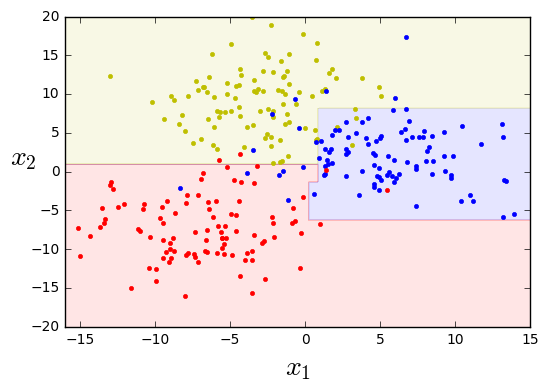

In [7]:
# Instantiate the classifier class for a deeper tree 
tree_clf = DecisionTreeClassifier(max_depth=3, random_state=42)

# Grow a Decision Tree
tree_clf.fit(X, y)

plot_feature_space(tree_clf, X, y, axes=[-16, 15, -20, 20], file_name='max_depth3.png')

If left unconstrained the algorithm tries hard to fit the data, learning every single data point's class and thus producing an overcomplicated model.

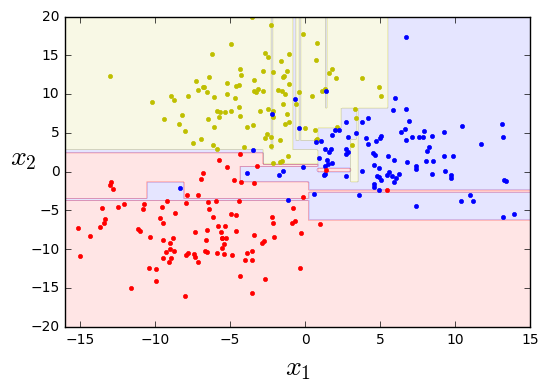

In [8]:
# Instantiate the classifier class with no limits
tree_clf = DecisionTreeClassifier(random_state=42)

# Grow a Decision Tree
tree_clf.fit(X, y)

plot_feature_space(tree_clf, X, y, axes=[-16, 15, -20, 20], file_name='unlimited.png')

Additional regularization parameters provided by `scikit-learn` are the minimum number of instances in a node before it can be split, the minimum number of instances in a leaf node, the maximum number of leaf nodes, and the maximum number of features that are evaluated for each split.

Decision Trees can also be used for regression problems instead of Classification with very minor changes. The tree is grown in the same way, using the CART algorithm, except that instead of minimizing node impurity it minimizes the mean squared error (MSE). It then simply predicts the average value of all data observations at eachn node, instead of the most common class.

<a id='forests'></a>
# 3. Random Forests

## 3.1 Building an ensemble of Decision Trees

An ensemble of Decision Trees is called a _Random Forest_. Random Forests are an example of an ensemble using the same ML algorithm to build multiple models each trained on a different random subset of the training data. When the training data sampling for each predictor is performed with replacement, the method is called _Boosted aggregating_, commonly abbreviated to _Bagging_. Sampling without replacement is called _Pasting_. After growing the Random Forest, i.e. training the chosen number of Decision Trees, the individual Decision Trees vote to reach the final prediction. Voting can be done in two ways, called _hard voting_ and _soft voting_. Hard voting consists using the statistical mode of the predicted classes, i.e. the most commonly predicted class. Soft voting consists on outputing the highest class probability, averaged over all the individual classifiers. This, of course, requires that the predictors can estimate class probabilities.

The final result is typically a model with similar bias but a lower variance than a single Decision Tree trained on the same data. This means that the decision boundary is typically less irregular. Let's see what that looks like by using `scikit-kearn`'s `BaggingClassifier` to grow a Random Forest. Let's grow, say, 50 Decision Trees, each trained on a random sample of 50 training set instances. `scikit-learn` also allows us to parallelize the work, with the `n_jobs` parameter. This is another nice side-effect of the algorithm: the individual predictors can be trained completely independently of each other. Let's set it to `n_jobs=-1`, which evaluates to the number of available cores.

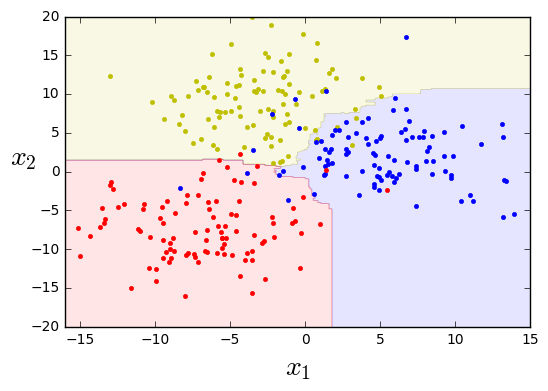

In [10]:
from sklearn.ensemble import BaggingClassifier

bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=50,
                            max_samples=50, bootstrap=True, n_jobs=-1,
                            oob_score=True, random_state=42)

bag_clf.fit(X, y)

plot_feature_space(bag_clf, X, y, axes=[-16, 15, -20, 20], file_name='bagging.png')

The decision boundaries look much smoother and definitely seem like they will generalize much better. An interesting side-effect of the bagging procedure is that a subset of the instances will not be sampled during training, the so-called _out-of_bag_ instances. The model will not have seen the _out-of_bag_ instances at all during training and so they can actually be used as a test set, in a procedure known as _Out-of-bag Evaluation_. Parameter `oob_score=True` above tells `scikit-learn` to perform Out-of-bag Evaluation after training and we can now use the attribute `oob_score_` to check the score.

In [11]:
print('Out-of-bag evaluation score: {}%'.format(round(bag_clf.oob_score_, 4)*100))

Out-of-bag evaluation score: 91.0%


## 3.2 The `RandomForestClassifier` class

As you may know, `scikit-learn` actually has a `RandomForestClassifier` class pre-built for you, so you can leave the bagging classifier class to use when you're bagging other models for your custom-built ensembles. This class will train a Random Forest using the specified number of Decision Trees using the whole training set for each individual model. One other main difference compared to the bagging classifier built above is that it introduces additional randomness by using, not only a random subset of the data, but also a random subset of the features at each split. This favors lower variance (and higher bias), helping with the tendency of the trees to overfit the data. Let's build a Random Forest with the `RandomForestClassifier` class and an additional regularization hyperparameter by setting `max_leaf_nodes=10`.

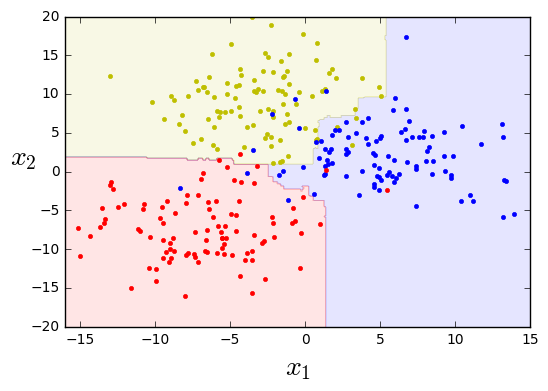

In [12]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=50, max_leaf_nodes=10, n_jobs=-1,
                                bootstrap=True,
                                oob_score=True, random_state=42)

rf_clf.fit(X, y)

plot_feature_space(rf_clf, X, y, axes=[-16, 15, -20, 20], file_name='random_forest.png')

In [13]:
print('Out-of-bag evaluation score: {}%'.format(round(rf_clf.oob_score_, 4)*100))

Out-of-bag evaluation score: 91.33%


<a id='extra_trees'></a>
# 4. Extremely Randomized Trees

`scikit-learn` provides yet another ensemble algorithm introducing additional randomness: the _Extremely Randomized Trees_ ensemble or _Extra-Trees_. Besides considering only a subset of the data set at each node, the Extra-Tree algorithm uses random splitting thresholds for each feature, rather than searching for the best threshold, to make its Decision Tree predictors even more random. Here's what it looks like with our toy data.

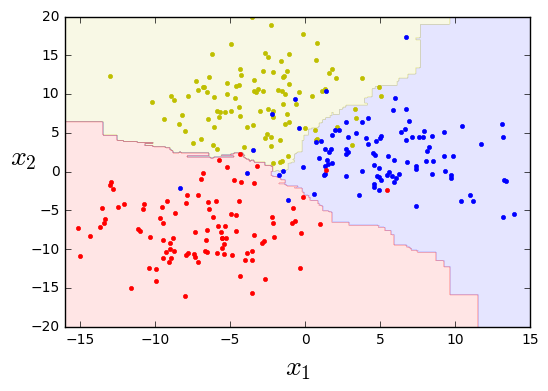

In [14]:
from sklearn.ensemble import ExtraTreesClassifier

extra_clf = ExtraTreesClassifier(n_estimators=50, max_leaf_nodes=10, n_jobs=-1,
                                 bootstrap=True,
                                 oob_score=True, random_state=42)

extra_clf.fit(X, y)

plot_feature_space(extra_clf, X, y, axes=[-16, 15, -20, 20], file_name='extra_trees.png')

In [15]:
print('Out-of-bag evaluation score: {}%'.format(round(extra_clf.oob_score_, 4)*100))

Out-of-bag evaluation score: 92.0%


The decision boundaries look even more natural, right?

[Back to top](#top)